In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Avec raster modifié dans QGIS

ajouter import error si le CRS n'est pas le bon

In [2]:
new_raster_path = "Data/espg2056_raster.tif"  

Charger les vols

In [3]:
cols = ['gps_time', 'lon', 'lat', 'alt', 'roll', 'pitch', 'yaw']
flight = pd.read_csv("Data/Vallet2020_CH1903.txt", names=cols, header=None)
flight.head()

,gps_time,lon,lat,alt,roll,pitch,yaw
0,396250.002499,2.530257e+06,1.157584e+06,456.211817,0.050645,0.102655,0.062425
1,396250.007500,2.530257e+06,1.157584e+06,456.212000,0.050491,0.102813,0.062119
2,396250.012500,2.530257e+06,1.157584e+06,456.212091,0.050305,0.102965,0.061815
3,396250.017500,2.530257e+06,1.157584e+06,456.212304,0.050074,0.103109,0.061515
4,396250.022500,2.530257e+06,1.157584e+06,456.212548,0.049815,0.103256,0.061216


Extracting flights 1 & 2

In [23]:
t1_start = 396528.0
t1_end = 396666.0
t2_start = 396724.0
t2_end = 396844.0

flight_1 = flight[(flight['gps_time'] >= t1_start) & (flight['gps_time'] <= t1_end)]
flight_2 = flight[(flight['gps_time'] >= t2_start) & (flight['gps_time'] <= t2_end)]

print('length:', len(flight_1), len(flight_2))

length: 27601 24000


get mean position of the two flights for plotting prupose and get ar the right place for the MNT

In [24]:
E_center = int((flight_1['lon'].mean() + flight_2['lon'].mean()) / 2)
N_center = int((flight_1['lat'].mean() + flight_2['lat'].mean()) / 2)
print(f'mean E: {E_center}, mean N: {N_center}')

mean E: 2530083, mean N: 1157198


estimate size of flights and area covered

In [25]:
E_min_flight = min(flight_1['lon'].min(), flight_2['lon'].min())
E_max_flight = max(flight_1['lon'].max(), flight_2['lon'].max())
N_min_flight = min(flight_1['lat'].min(), flight_2['lat'].min())
N_max_flight = max(flight_1['lat'].max(), flight_2['lat'].max())


print('flight:')
print(f"E_min = {E_min_flight}")
print(f"E_max = {E_max_flight}")
print(f"N_min = {N_min_flight}")
print(f"N_max = {N_max_flight}")

E_min_map = int(E_min_flight) - 250
E_max_map = int(E_max_flight) + 250
N_min_map = int(N_min_flight) - 250
N_max_map = int(N_max_flight) + 250

print('\nMap:')
print(f"E_min = {E_min_map}")
print(f"E_max = {E_max_map}")
print(f"N_min = {N_min_map}")
print(f"N_max = {N_max_map}")

flight:
E_min = 2529289.38212453
E_max = 2530931.5503964
N_min = 1156909.29642851
N_max = 1157464.33532841

Map:
E_min = 2529039
E_max = 2531181
N_min = 1156659
N_max = 1157714


Generate map with arbitrary size patch -> not useful

461.9
2529039 1157714
Types: <class 'str'>, <class 'rasterio.crs.CRS'>


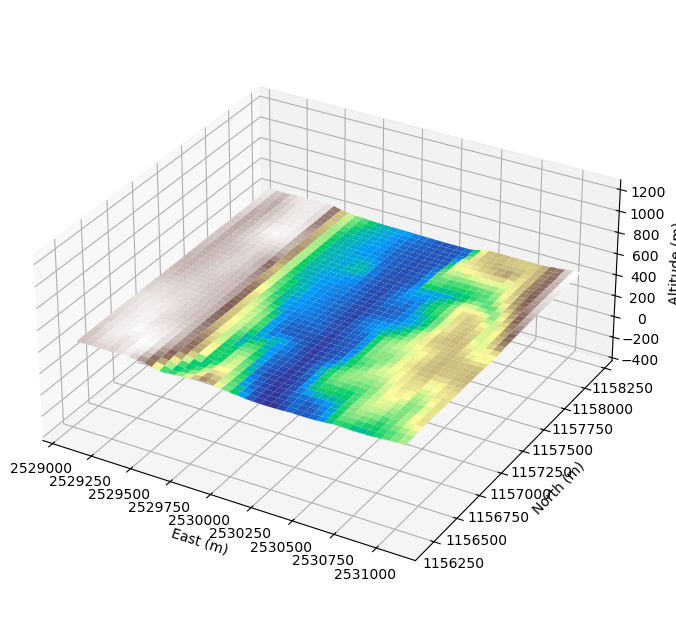

In [27]:
# Arbitrary size patch
patch_size_m = 2000 
half_patch_size = patch_size_m / 2

# Bounding box
east_min = E_center - half_patch_size
east_max = E_center + half_patch_size
north_min = N_center - half_patch_size
north_max = N_center + half_patch_size

with rasterio.open(new_raster_path) as src:
    row_start, col_start = src.index(E_min_map, N_max_map)  # Top-left corner
    row_end, col_end = src.index(E_max_map, N_min_map)  # Bottom-right corner

    window = rasterio.windows.Window.from_slices((row_start, row_end), (col_start, col_end))
    patch_data = src.read(1, window=window)
    print(patch_data[0][0])
    print(E_min_map, N_max_map)
    # geographic coordinates for the grid of this patch
    x_coords = np.linspace(east_min, east_max, patch_data.shape[1])
    y_coords = np.linspace(north_max, north_min, patch_data.shape[0])

    x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)
    

    epsg=2056
    # For debugging
    a = f'EPSG:{epsg}'
    b = src.crs
    print(f"Types: {type(a)}, {type(b)}")
    if src.crs != rasterio.crs.CRS.from_epsg(epsg):
        print('hello')
        current_epsg = src.crs.to_epsg() or "unknown"
        raise ValueError(f"Raster is not in EPSG:{epsg}. Current CRS: EPSG:{current_epsg}")
        
    

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh, y_mesh, patch_data, cmap='terrain', edgecolor='none')

ax.axis('equal')
ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
ax.set_zlabel('Altitude (m)')
ax.ticklabel_format(style='plain', axis='both', useOffset=False)
ax.set_box_aspect([1, 1, 0.5])

plt.show()


In [28]:

# Define LiDAR parameters
lidar_FOV_deg = 75  # Field of view angle in degrees
lidar_FOV_rad = np.radians(lidar_FOV_deg / 2)

# Extract coordinates from single plane path 
flight_E = flight_1['lon']
flight_N = flight_1['lat']
flight_alt = flight_1['alt']


flights = {
    'flight_1': {
        'E':   flight_1['lon'],
        'N':   flight_1['lat'],
        'alt': flight_1['alt']
    },
    'flight_2': {
        'E':   flight_2['lon'],
        'N':   flight_2['lat'],
        'alt': flight_2['alt']
    },
}

for flight_key, flight_data in flights.items():
    print(f"Processing {flight_key}")
    
    flight_E = flight_data['E']
    flight_N = flight_data['N']
    flight_alt = flight_data['alt']
    
# then compute the mean to center to all flights recorded
E_center = int((flight_1['lon'].mean() + flight_2['lon'].mean()) / 2)
N_center = int((flight_1['lat'].mean() + flight_2['lat'].mean()) / 2)
print(f'mean E: {E_center}, mean N: {N_center}')
    

Processing flight_1
Processing flight_2
mean E: 2530083, mean N: 1157198


EPSG:2056
Patch data shape: (44, 87)
x_mesh, y_mesh shape: ((44, 87), (44, 87))


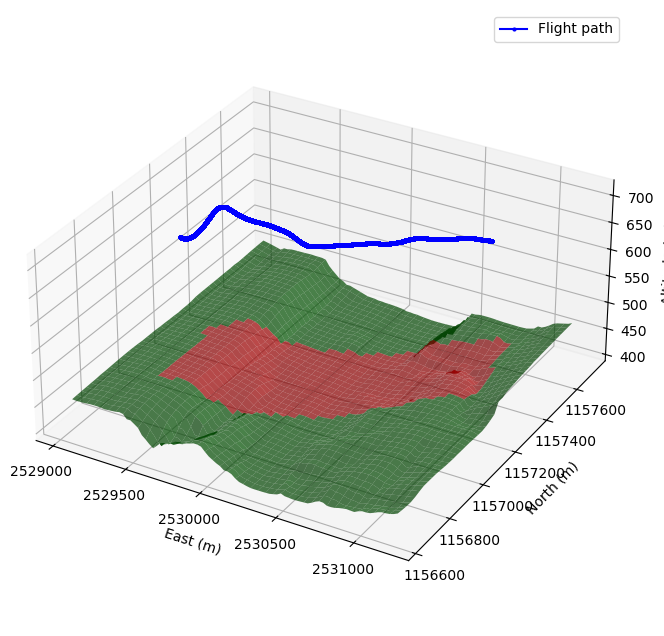

In [29]:

with rasterio.open(new_raster_path) as src:
    
    # Get raster resolution (pixel size in x and y)
    res_x, res_y = src.res
    print(src.crs)
    
    # Ensure correct number of points in x/y
    x_coords = np.arange(E_min_map, E_max_map + res_x, res_x)  # Add `+res_x`
    y_coords = np.arange(N_max_map, N_min_map - res_y, -res_y)  # Add `-res_y`
    x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)

    # Get the exact raster indices for slicing
    row_start, col_start = src.index(x_coords[0], y_coords[0])  # Top-left corner
    row_end, col_end     = src.index(x_coords[-1], y_coords[-1])  # Bottom-right corner

    # Create the rasterio window
    window = rasterio.windows.Window.from_slices(
        (row_start, row_end + 1),  # Add +1 to include last row
        (col_start, col_end + 1)   # Add +1 to include last column
    )
    
    patch_data = src.read(1, window=window)

    # Final shape check
    print(f"Patch data shape: {patch_data.shape}")
    print(f"x_mesh, y_mesh shape: {x_mesh.shape, y_mesh.shape}")
    

# Mask to highlight observed zones
observed_mask = np.zeros_like(patch_data, dtype=bool)

# Compute the direction (heading) of the plane
flight_dir = np.diff(np.column_stack((flight_E, flight_N)), axis=0)  # (dx, dy) between consecutive points
flight_dir /= np.linalg.norm(flight_dir, axis=1)[:, np.newaxis]  # Normalize to unit vectors

# Add the last point again to maintain the same length for direction arrays
flight_dir = np.vstack((flight_dir, flight_dir[-1]))

# Mark observed zones on the ground based on drone positions and LiDAR angle
for e, n, alt in zip(flight_E, flight_N, flight_alt):

    # horizontal distances for each grid point
    horizontal_distances = np.sqrt((x_mesh - e)**2 + (y_mesh - n)**2)
    #print(np.shape(horizontal_distances))
    #print(horizontal_distances)
    # vertical distances for each grid point
    vertical_distances = alt - patch_data  
    #print(np.shape(vertical_distances))
    # angle of the line of sight to each grid point
    line_of_sight_angles = np.arctan2(horizontal_distances, vertical_distances)
    
    # update of previous observed_mask using |=
    observed_mask |= (np.abs(line_of_sight_angles) <= lidar_FOV_rad) 
    
# clear start and end footprint MAKE SOMETHING GENERIC
dir_x_start, dir_y_start = flight_dir[0]
pos_x_start, pos_y_start = (flight_E.iloc[0], flight_N.iloc[0])

trajectory_angle = np.arctan2(dir_x_start, dir_y_start)
angle_to_grid = np.arctan2(x_mesh - pos_x_start, y_mesh - pos_y_start)
angle_diff = np.abs(angle_to_grid - trajectory_angle)

observed_mask &= ~(angle_diff > np.pi / 2)  # Clear behind the flight path

dir_x_stop, dir_y_stop = flight_dir[-1]
pos_x_stop, pos_y_stop = (flight_E.iloc[-1], flight_N.iloc[-1])

trajectory_angle = np.arctan2(dir_x_stop, dir_y_stop)
angle_to_grid = np.arctan2(x_mesh - pos_x_stop, y_mesh - pos_y_stop)
angle_diff = np.abs(angle_to_grid - trajectory_angle)

observed_mask &= ~(angle_diff < np.pi / 2)  # Clear ahead of end 


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the plane flight path
ax.plot(flight_E, flight_N, flight_alt, color='blue', marker='o', markersize=2, label="Flight path")

# Plot the MNT with observed areas in red
ax.plot_surface(x_mesh, y_mesh, patch_data, facecolors=np.where(observed_mask, 'red', 'green'), edgecolor='none', alpha=0.7)
#ax.plot_surface(x_mesh, y_mesh, patch_data, cmap='terrain', edgecolor='none')


ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
ax.set_zlabel('Altitude (m)')
ax.ticklabel_format(style='plain', axis='both', useOffset=False)
ax.legend()
ax.set_box_aspect([1, 1, 0.5])

plt.show()

#E_min = 2529039
#E_max = 2531181


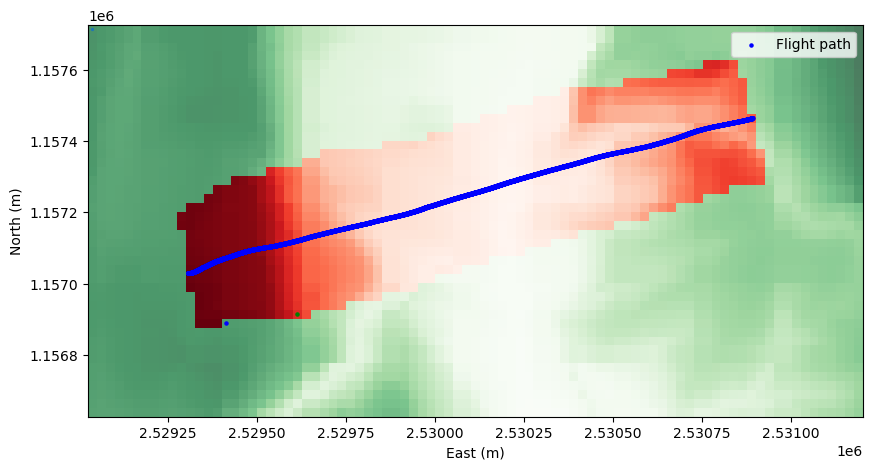

In [30]:

# Plot the 2D view
fig, ax = plt.subplots(figsize=(10, 8))

ax.pcolormesh(x_mesh, y_mesh, patch_data, cmap='Greens', alpha=0.7)

ax.pcolormesh(
    x_mesh, y_mesh, np.where(observed_mask, patch_data, np.nan), cmap='Reds', shading='auto'
)

ax.scatter(flight_E, flight_N, color='blue', label="Flight path", s=5) 

# le centre de chaque tuile est bien la coordonnées souhaitée !
ax.scatter(x_mesh[0][15], y_mesh[33][0],s=5 , color = 'blue')
ax.scatter(x_mesh[0][23], y_mesh[32][0],s=5 , color = 'green')

ax.set_xlabel("East (m)")
ax.set_ylabel("North (m)")
ax.legend()
ax.set_aspect('equal', adjustable='box')
ax.scatter(2529039, 1157714, s=2)

plt.show()


Adding a 2nd flight > Generic 

In [31]:
do_crop=True

with rasterio.open(new_raster_path) as src:
    
    # Get raster resolution (pixel size in x and y)
    res_x, res_y = src.res
    
    # Ensure correct number of points in x/y
    x_coords = np.arange(E_min_map, E_max_map + res_x, res_x)  # Add `+res_x`
    y_coords = np.arange(N_max_map, N_min_map - res_y, -res_y)  # Add `-res_y`
    x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)

    # Get the exact raster indices for slicing
    row_start, col_start = src.index(x_coords[0], y_coords[0])  # Top-left corner
    row_end, col_end     = src.index(x_coords[-1], y_coords[-1])  # Bottom-right corner

    # Create the rasterio window
    window = rasterio.windows.Window.from_slices(
        (row_start, row_end + 1),  # Add +1 to include last row
        (col_start, col_end + 1)   # Add +1 to include last column
    )
    
    patch_data = src.read(1, window=window)

# Create masks depending on the number of flights (3d array)
superpos_masks = []
obs_masks = []

for flight_key, flight_data in flights.items():
    print(f"Processing {flight_key}")
    flight_E = flight_data['E']
    flight_N = flight_data['N']
    flight_alt = flight_data['alt']
    
    # Initialize the mask for this flight
    observed_mask = np.zeros_like(patch_data, dtype=bool)
    
    # Compute the direction (heading) of the plane
    flight_dir = np.diff(np.column_stack((flight_E, flight_N)), axis=0)  # (dx, dy) between consecutive points
    flight_dir /= np.linalg.norm(flight_dir, axis=1)[:, np.newaxis]  # Normalize to unit vectors

    # Add the last point again to maintain the same length for direction arrays
    flight_dir = np.vstack((flight_dir, flight_dir[-1]))

    # Mask to highlight observed zones based on current flight data
    for e, n, alt in zip(flight_E, flight_N, flight_alt):
        # Horizontal distances for each grid point
        horizontal_distances = np.sqrt((x_mesh - e)**2 + (y_mesh - n)**2)

        # Vertical distances for each grid point
        vertical_distances = alt - patch_data  

        # Angle of the line of sight to each grid point
        line_of_sight_angles = np.arctan2(horizontal_distances, vertical_distances)

        # Update the observed_mask for this flight
        observed_mask |= (np.abs(line_of_sight_angles) <= lidar_FOV_rad)
    # clear start and end footprint MAKE SOMETHING GENERIC
    if do_crop: 
        dir_x_start, dir_y_start = flight_dir[0]
        pos_x_start, pos_y_start = (flight_E.iloc[0], flight_N.iloc[0])

        trajectory_angle = np.arctan2(dir_x_start, dir_y_start)
        angle_to_grid = np.arctan2(x_mesh - pos_x_start, y_mesh - pos_y_start)
        angle_diff = np.abs(angle_to_grid - trajectory_angle)

        observed_mask &= ~(angle_diff > np.pi / 2)  # Clear behind the flight path

        dir_x_stop, dir_y_stop = flight_dir[-1]
        pos_x_stop, pos_y_stop = (flight_E.iloc[-1], flight_N.iloc[-1])

        trajectory_angle = np.arctan2(dir_x_stop, dir_y_stop)
        angle_to_grid = np.arctan2(x_mesh - pos_x_stop, y_mesh - pos_y_stop)
        angle_diff = np.abs(angle_to_grid - trajectory_angle)

        observed_mask &= ~(angle_diff < np.pi / 2)  # Clear ahead of end 
    
    obs_masks.append(observed_mask)

print(np.shape(obs_masks))
combined_mask = obs_masks[0] & obs_masks[1]
superpos_masks.append(combined_mask)
print(np.shape(superpos_masks))

print(2529064.5-2529039.)



Processing flight_1
Processing flight_2
(2, 44, 87)
(1, 44, 87)
25.5


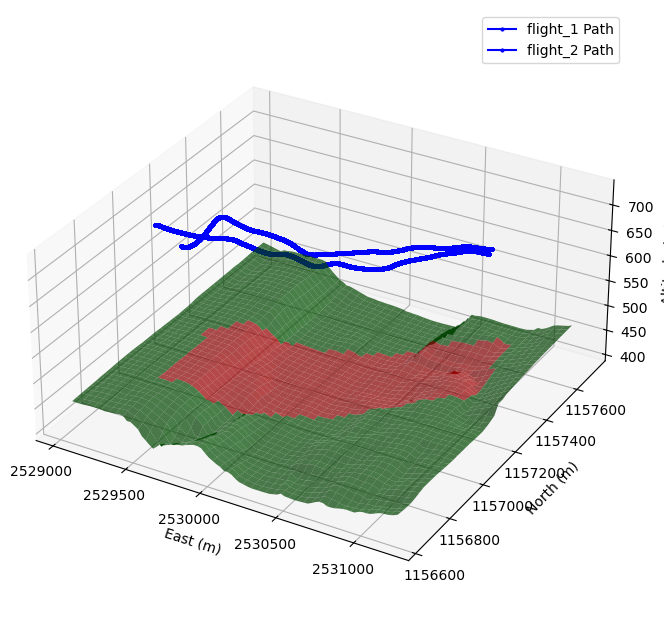

In [32]:

# Plotting the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the flight paths in blue
for flight_key, flight_data in flights.items():
    ax.plot(flight_data['E'], flight_data['N'], flight_data['alt'], color='blue', marker='o', markersize=2, label=f"{flight_key} Path")

# Plot the MNT (elevation data) with observed areas in red
ax.plot_surface(x_mesh, y_mesh, patch_data, facecolors=np.where(observed_mask, 'red', 'green'), edgecolor='none', alpha=0.7)

# Axes labels and formatting
ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
ax.set_zlabel('Altitude (m)')
ax.ticklabel_format(style='plain', axis='both', useOffset=False)
ax.legend()
ax.set_box_aspect([1, 1, 0.5])

# Display the plot
plt.show()

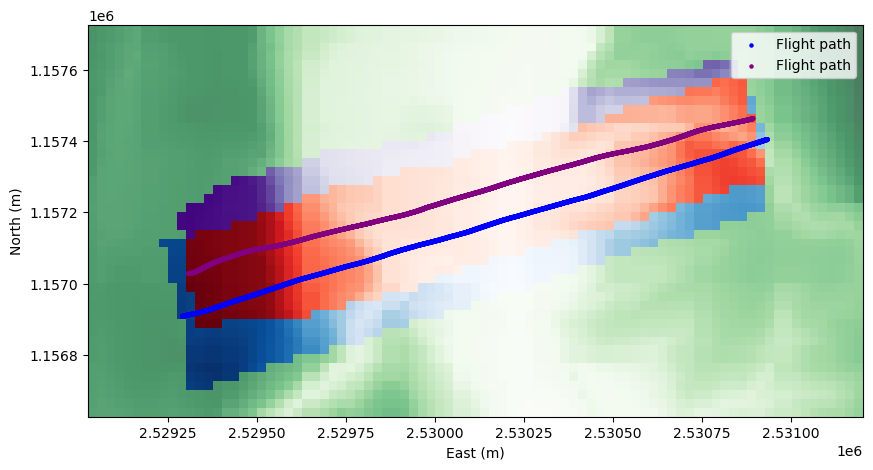

In [33]:
# Plot the 2D view
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the terrain
ax.pcolormesh(x_mesh, y_mesh, patch_data, cmap='Greens', alpha=0.7)

# Overlay the observed mask in red
ax.pcolormesh(
    x_mesh, y_mesh, np.where(obs_masks[0], patch_data, np.nan), cmap='Blues', shading='auto'
)
ax.pcolormesh(
    x_mesh, y_mesh, np.where(obs_masks[1], patch_data, np.nan), cmap='Purples', shading='auto'
)
ax.pcolormesh(
    x_mesh, y_mesh, np.where(superpos_masks[0], patch_data, np.nan), cmap='Reds', shading='auto'
)

colors = ['blue', 'purple']
for i, (flight_key, flight_data) in enumerate(flights.items()):
    ax.scatter(flight_data['E'], flight_data['N'], color=colors[i % len(colors)], label="Flight path", s=5) 

# Adding labels and title
ax.set_xlabel("East (m)")
ax.set_ylabel("North (m)")
ax.set_aspect('equal')
ax.legend()

plt.show()


Now, try to fit a polygon to the superposition raster..

0


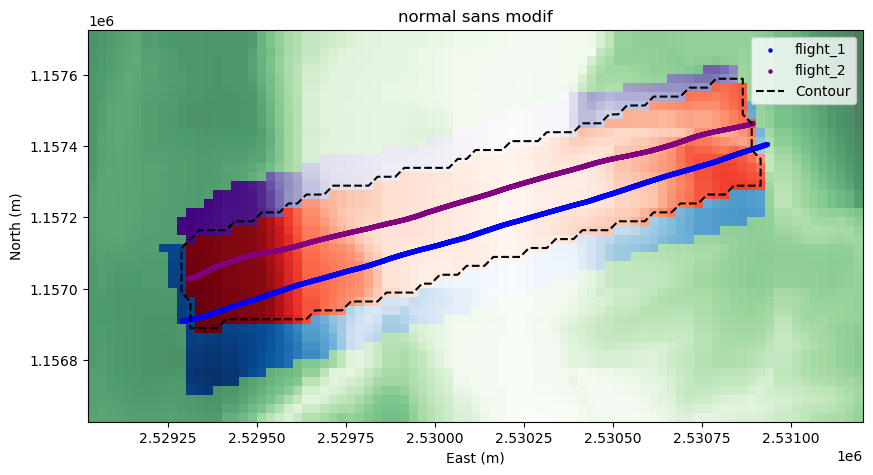

In [116]:
from skimage.measure import find_contours, approximate_polygon
from shapely.geometry import Polygon

polygon_list = []

for i, contour in enumerate(find_contours(superpos_masks[0].astype(int))):
    print(i)
    coords = approximate_polygon(contour, tolerance=0.05)

    contour_x = coords[:, 1].astype(int)  # Column indices
    contour_y = coords[:, 0].astype(int)  # Row indices
    
    # Convert indices to Swiss coordinates
    contour_coords = np.array([x_mesh[contour_y, contour_x], y_mesh[contour_y, contour_x]]).T


# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Terrain
ax.pcolormesh(x_mesh, y_mesh, patch_data, cmap='Greens', alpha=0.7)

# P?lot masks
ax.pcolormesh(x_mesh, y_mesh, np.where(obs_masks[0], patch_data, np.nan), cmap='Blues', shading='auto')
ax.pcolormesh(x_mesh, y_mesh, np.where(obs_masks[1], patch_data, np.nan), cmap='Purples', shading='auto')
ax.pcolormesh(x_mesh, y_mesh, np.where(superpos_masks[0], patch_data, np.nan), cmap='Reds', shading='auto')

# Flights
colors = ['blue', 'purple']
for i, (flight_key, flight_data) in enumerate(flights.items()):
    ax.scatter(flight_data['E'], flight_data['N'], color=colors[i % len(colors)], label=flight_key, s=5)

# Plot of contour
ax.plot(contour_coords[:,0], contour_coords[:,1], '--', color='black', label='Contour')

ax.set_xlabel("East (m)")
ax.set_ylabel("North (m)")
ax.set_aspect('equal')
ax.set_title('normal sans modif')
ax.legend()

plt.show()

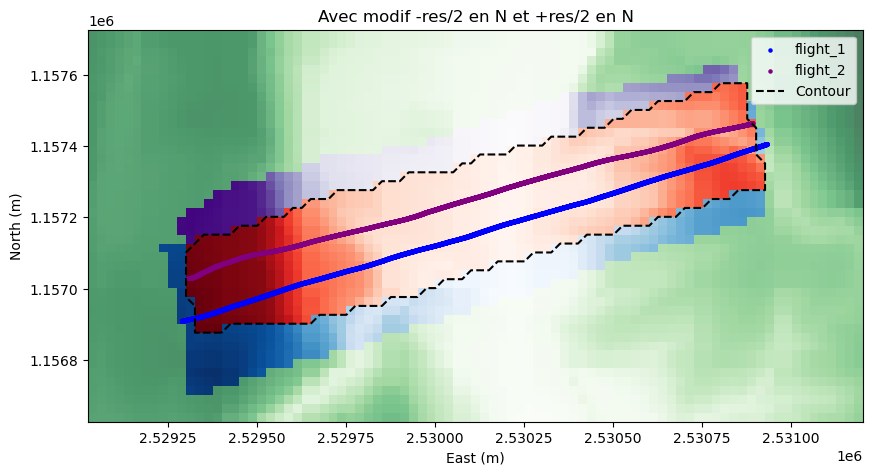

In [118]:

polygon_list = []
for contour in find_contours(superpos_masks[0].astype(int)):
    coords = approximate_polygon(contour, tolerance=0.05)

    contour_x = coords[:, 1].astype(int)  # Column indices
    contour_y = coords[:, 0].astype(int)  # Row indices
    
    # Convert indices to Swiss coordinates
    contour_coords = np.array([x_mesh[contour_y, contour_x]+25/2, y_mesh[contour_y, contour_x]-25/2]).T


# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Terrain
ax.pcolormesh(x_mesh, y_mesh, patch_data, cmap='Greens', alpha=0.7)

# P?lot masks
ax.pcolormesh(x_mesh, y_mesh, np.where(obs_masks[0], patch_data, np.nan), cmap='Blues', shading='auto')
ax.pcolormesh(x_mesh, y_mesh, np.where(obs_masks[1], patch_data, np.nan), cmap='Purples', shading='auto')
ax.pcolormesh(x_mesh, y_mesh, np.where(superpos_masks[0], patch_data, np.nan), cmap='Reds', shading='auto')

# Flights
colors = ['blue', 'purple']
for i, (flight_key, flight_data) in enumerate(flights.items()):
    ax.scatter(flight_data['E'], flight_data['N'], color=colors[i % len(colors)], label=flight_key, s=5)

# Plot of contour
ax.plot(contour_coords[:,0], contour_coords[:,1], '--', color='black', label='Contour')

ax.set_xlabel("East (m)")
ax.set_ylabel("North (m)")
ax.set_aspect('equal')
ax.set_title('Avec modif -res/2 en N et +res/2 en N')
ax.legend()

plt.show()


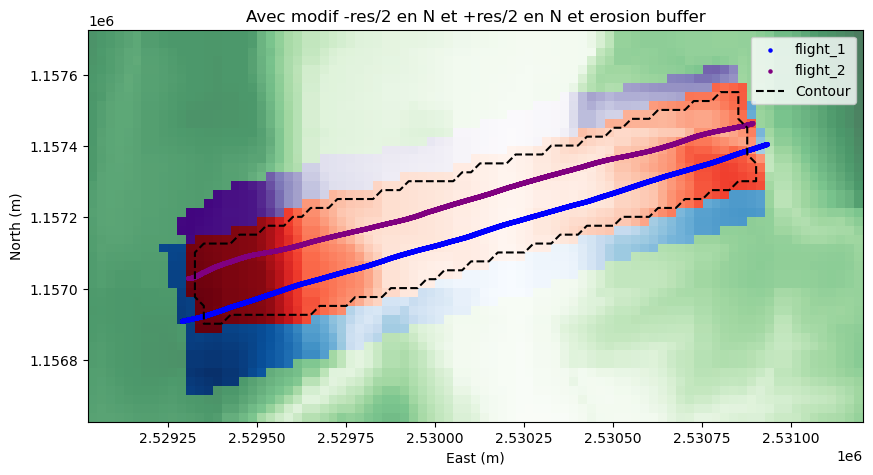

In [36]:
from skimage.morphology import binary_erosion

buffered_mask = binary_erosion(superpos_masks[0].astype(int))  

polygon_list = []
for contour in find_contours(buffered_mask):
    coords = approximate_polygon(contour, tolerance=0.001)

    contour_x = coords[:, 1].astype(int)  # Column indices
    contour_y = coords[:, 0].astype(int)  # Row indices
    
    # Convert indices to Swiss coordinates
    contour_coords3 = np.array([x_mesh[contour_y, contour_x]+25/2, y_mesh[contour_y, contour_x]-25/2]).T
    # Pas sur que j'ai besoin de polygon en fin de compte 
    #polygon_list.append(Polygon(swiss_coords))

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Terrain
ax.pcolormesh(x_mesh, y_mesh, patch_data, cmap='Greens', alpha=0.7)

# Plot masks
ax.pcolormesh(x_mesh, y_mesh, np.where(obs_masks[0], patch_data, np.nan), cmap='Blues', shading='auto')
ax.pcolormesh(x_mesh, y_mesh, np.where(obs_masks[1], patch_data, np.nan), cmap='Purples', shading='auto')
ax.pcolormesh(x_mesh, y_mesh, np.where(superpos_masks[0], patch_data, np.nan), cmap='Reds', shading='auto')

# Flights
colors = ['blue', 'purple']
for i, (flight_key, flight_data) in enumerate(flights.items()):
    ax.scatter(flight_data['E'], flight_data['N'], color=colors[i % len(colors)], label=flight_key, s=5)

# Plot of contour
ax.plot(contour_coords3[:,0], contour_coords3[:,1], '--', color='black', label='Contour')

ax.set_xlabel("East (m)")
ax.set_ylabel("North (m)")
ax.set_aspect('equal')
ax.set_title('Avec modif -res/2 en N et +res/2 en N et erosion buffer')
ax.legend()

plt.show()


Notes intermédiaires: 
- limitation de la resolution car il se base sur le haut des tuiles donc on a plus d'espace au Sud qu'au Nord des tuiles -> ajustement N et E en ± res/2 
- avec le buffer érodé notre contour reste dans la zone de superposition

- Coef de **tolerance** arbitraire 


Autre methode: en utilisant medial_axis et skeleton de skimage 

Text(0.5, 1.0, 'Medial Axis')

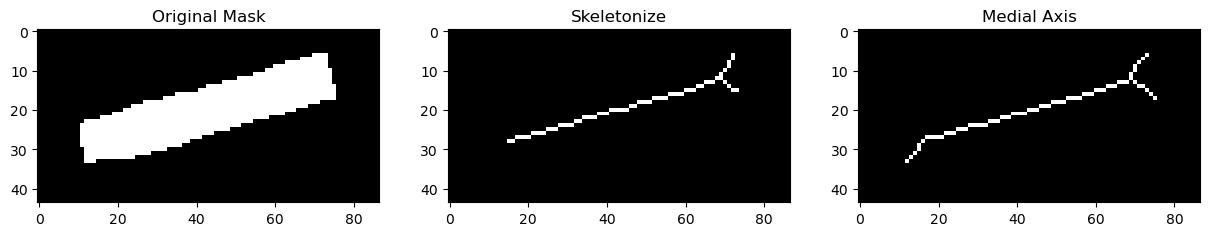

In [37]:
from skimage import morphology

binary_mask = superpos_masks[0].astype(int)

skeleton = morphology.skeletonize(binary_mask)

medial = morphology.medial_axis(binary_mask)

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original mask
axes[0].imshow(binary_mask, cmap='gray')
axes[0].set_title("Original Mask")

# Skeletonized result
axes[1].imshow(skeleton, cmap='gray')
axes[1].set_title("Skeletonize")

# Medial axis result
axes[2].imshow(medial, cmap='gray')
axes[2].set_title("Medial Axis")

In [38]:

medial_axis_coords = np.column_stack(np.where(medial))  # (row, col)

medial_x = medial_axis_coords[:, 1].astype(int) # Column indices
medial_y = medial_axis_coords[:, 0].astype(int) # Row indices

coord_medial = np.array([x_mesh[medial_y, medial_x]+25/2, y_mesh[medial_y, medial_x]-25/2]).T

# pareil avec skeleton

skeleton_coords = np.column_stack(np.where(skeleton))  # (row, col)

skeleton_x = skeleton_coords[:, 1].astype(int) # Column indices
skeleton_y = skeleton_coords[:, 0].astype(int) # Row indices

coord_skeleton = np.array([x_mesh[skeleton_y, skeleton_x]+25/2, y_mesh[skeleton_y, skeleton_x]-25/2]).T


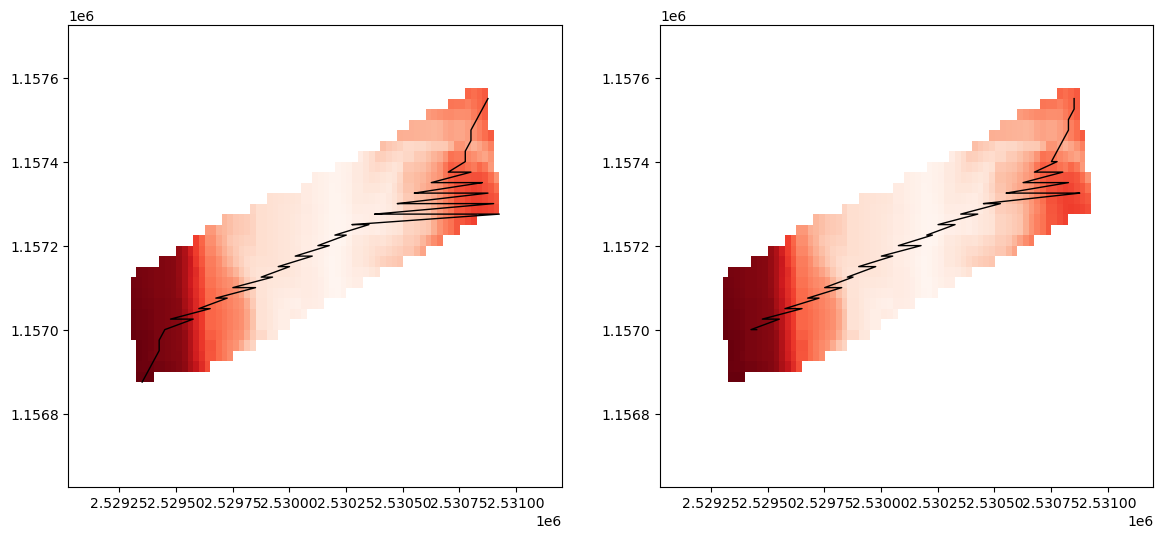

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].pcolormesh(x_mesh, y_mesh, np.where(superpos_masks[0], patch_data, np.nan), cmap='Reds', shading='auto')
ax[0].plot(coord_medial[:, 0], coord_medial[:, 1], '-', color='black', label='medial_axis', linewidth=1)

ax[1].pcolormesh(x_mesh, y_mesh, np.where(superpos_masks[0], patch_data, np.nan), cmap='Reds', shading='auto')
ax[1].plot(coord_skeleton[:, 0], coord_skeleton[:, 1], '-', color='black', label='skeleton', linewidth=1)



plt.show()

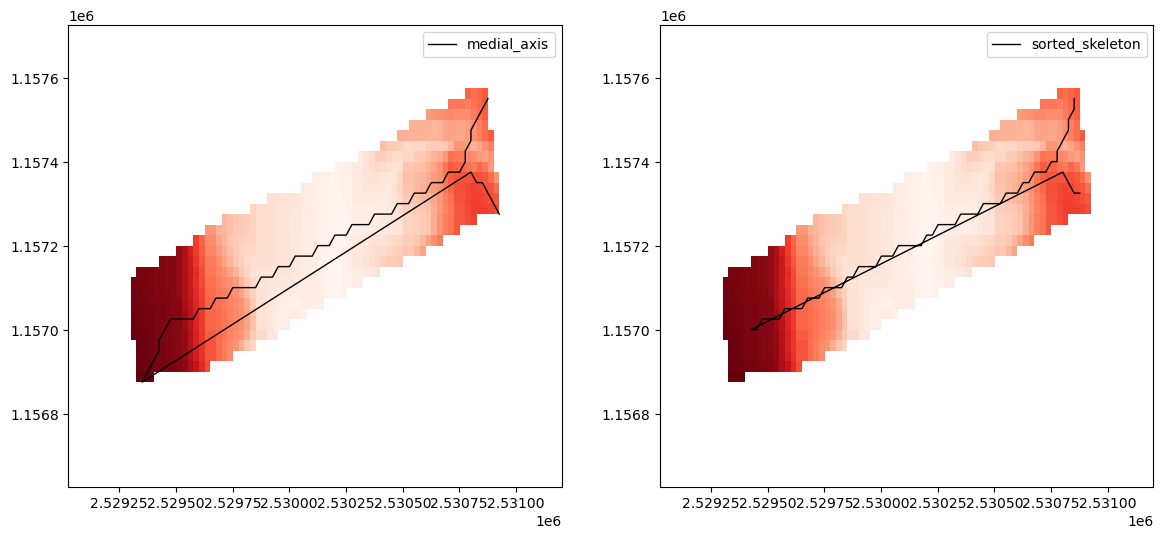

In [40]:
def sort_points_by_proximity(coords):
    # Start with the first point
    sorted_coords = [coords[0]]
    remaining_coords = coords[1:].tolist()
    
    while remaining_coords:
        last_point = sorted_coords[-1]
        distances = np.linalg.norm(np.array(remaining_coords) - last_point, axis=1)
        closest_point_index = np.argmin(distances)
        closest_point = remaining_coords.pop(closest_point_index)
        sorted_coords.append(closest_point)
    
    return np.array(sorted_coords)

# Sort the skeleton points to avoid zigzags
sorted_skeleton = sort_points_by_proximity(coord_skeleton)
sorted_medial_axis = sort_points_by_proximity(coord_medial)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first figure
ax[0].pcolormesh(x_mesh, y_mesh, np.where(superpos_masks[0], patch_data, np.nan), cmap='Reds', shading='auto')
ax[0].plot(sorted_medial_axis[:, 0], sorted_medial_axis[:, 1], '-', color='black', label='medial_axis', linewidth=1)
ax[0].legend()
# Plot the second figure with sorted skeleton
ax[1].pcolormesh(x_mesh, y_mesh, np.where(superpos_masks[0], patch_data, np.nan), cmap='Reds', shading='auto')
ax[1].plot(sorted_skeleton[:, 0], sorted_skeleton[:, 1], '-', color='black', label='sorted_skeleton', linewidth=1)
ax[1].legend()

plt.show()


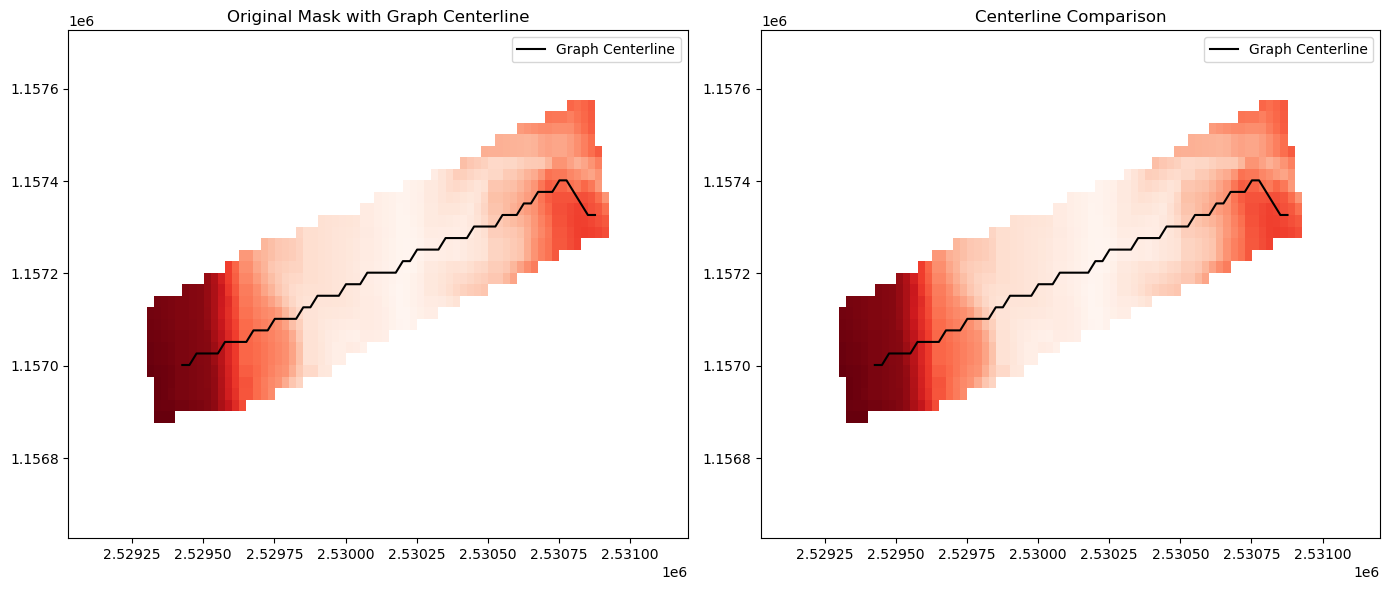

In [41]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from skimage import morphology
from scipy.ndimage import distance_transform_edt

def find_centerline_path(skeleton, x_mesh, y_mesh):
    """
    Find the main centerline path through a skeleton using graph analysis.
    
    Parameters:
    - skeleton: Binary skeleton image
    - x_mesh, y_mesh: Coordinate meshes for mapping back to original space
    
    Returns:
    - centerline_coords: Array of (x,y) coordinates representing the main path
    """
    # Get coordinates of skeleton points
    skeleton_coords = np.column_stack(np.where(skeleton))  # (row, col) format
    
    # Create graph
    G = nx.Graph()
    
    # Add all points as nodes
    for i, (row, col) in enumerate(skeleton_coords):
        # Map to original coordinate system
        x = x_mesh[row, col] + 25/2
        y = y_mesh[row, col] - 25/2
        G.add_node(i, pos=(x, y), original_pos=(row, col))
    
    # Connect neighboring points (8-connectivity)
    for i, (y1, x1) in enumerate(skeleton_coords):
        for j, (y2, x2) in enumerate(skeleton_coords):
            if i != j and abs(y1-y2) <= 1 and abs(x1-x2) <= 1:
                G.add_edge(i, j, weight=np.sqrt((y1-y2)**2 + (x1-x2)**2))
    
    # Find endpoints (nodes with only one connection)
    endpoints = [n for n, d in G.degree() if d == 1]
    
    if len(endpoints) >= 2:
        # Find the leftmost and rightmost endpoints
        pos = nx.get_node_attributes(G, 'pos')
        leftmost = min(endpoints, key=lambda n: pos[n][0])
        rightmost = max(endpoints, key=lambda n: pos[n][0])
        
        # Find the shortest path between these endpoints
        try:
            path = nx.shortest_path(G, leftmost, rightmost, weight='weight')
            
            # Convert back to coordinates
            centerline = np.array([pos[n] for n in path])
            return centerline
        except nx.NetworkXNoPath:
            print("No path found between endpoints.")
            return None
    else:
        # In case we have loops or no clear endpoints
        # Find nodes with highest betweenness centrality
        if len(G.nodes()) > 2:
            betweenness = nx.betweenness_centrality(G)
            sorted_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
            
            # Use the two highest betweenness nodes as endpoints
            node1, node2 = sorted_nodes[0][0], sorted_nodes[1][0]
            try:
                path = nx.shortest_path(G, node1, node2)
                pos = nx.get_node_attributes(G, 'pos')
                centerline = np.array([pos[n] for n in path])
                return centerline
            except nx.NetworkXNoPath:
                print("No path found between central nodes.")
                return None
        else:
            print("Not enough nodes to form a path.")
            return None

def handle_branches(skeleton):
    """
    Prune small branches from skeleton to get a cleaner centerline
    """
    # Distance transform to identify the main "trunk"
    distance = distance_transform_edt(skeleton)
    
    # Threshold the distance transform to keep only the main pathway
    pruned = skeleton.copy()
    pruned[distance < 0.8] = 0
    
    # Ensure connectivity is preserved
    labeled, num = morphology.label(pruned, connectivity=2, return_num=True)
    if num > 1:
        # Keep only the largest connected component
        largest_cc = morphology.remove_small_objects(labeled > 0, min_size=5)
        return largest_cc
    return pruned

# Process the skeleton before finding the path
def get_clean_centerline(binary_mask, x_mesh, y_mesh):
    """
    Main function to extract a clean centerline from a binary mask
    """
    # Generate the skeleton
    skeleton = morphology.skeletonize(binary_mask)
    
    # Handle any branching in the skeleton
    clean_skeleton = handle_branches(skeleton)
    
    # Find the centerline path
    centerline = find_centerline_path(clean_skeleton, x_mesh, y_mesh)
    
    return centerline, clean_skeleton

# Demonstration code (assumes superpos_masks, x_mesh, y_mesh are defined)
def demonstrate_centerline_extraction(binary_mask, x_mesh, y_mesh, patch_data):
    """
    Demonstrate the full centerline extraction process with visualization
    """
    centerline, clean_skeleton = get_clean_centerline(binary_mask, x_mesh, y_mesh)
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original mask
    axes[0].imshow(binary_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    
    # Clean skeleton
    skeleton_vis = np.zeros_like(binary_mask)
    skeleton_coords = np.column_stack(np.where(clean_skeleton))
    for row, col in skeleton_coords:
        skeleton_vis[row, col] = 1
    axes[1].imshow(skeleton_vis, cmap='gray')
    axes[1].set_title("Clean Skeleton")
    
    # Final centerline on original data
    axes[2].pcolormesh(x_mesh, y_mesh, np.where(binary_mask, patch_data, np.nan), 
                      cmap='Reds', shading='auto')
    if centerline is not None:
        axes[2].plot(centerline[:, 0], centerline[:, 1], 'o-', color='black', 
                    label='Graph Centerline', linewidth=1, markersize=2)
        axes[2].legend()
    axes[2].set_title("Centerline Result")
    
    plt.tight_layout()
    return fig, centerline

# Assuming you've already defined binary_mask, x_mesh, y_mesh, and patch_data

# 1. First get the centerline and clean skeleton
centerline, clean_skeleton = get_clean_centerline(binary_mask, x_mesh, y_mesh)

# 2. Create a plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 3. First subplot: Original mask with centerline
axes[0].pcolormesh(x_mesh, y_mesh, np.where(binary_mask, patch_data, np.nan), 
                   cmap='Reds', shading='auto')
if centerline is not None:
    axes[0].plot(centerline[:, 0], centerline[:, 1], '-', color='black', 
                label='Graph Centerline', linewidth=1.5)
    axes[0].legend()
axes[0].set_title("Original Mask with Graph Centerline")

# 4. Second subplot: Compare with your previous approaches
axes[1].pcolormesh(x_mesh, y_mesh, np.where(binary_mask, patch_data, np.nan), 
                  cmap='Reds', shading='auto')
# Plot the graph centerline
if centerline is not None:
    axes[1].plot(centerline[:, 0], centerline[:, 1], '-', color='black', 
                label='Graph Centerline', linewidth=1.5)
# Optionally plot your previous centerlines for comparison
# axes[1].plot(sorted_medial_axis[:, 0], sorted_medial_axis[:, 1], '--', 
#             color='blue', label='Medial Axis', linewidth=1)
axes[1].legend()
axes[1].set_title("Centerline Comparison")

plt.tight_layout()
plt.show()

linear regression to find a centerline

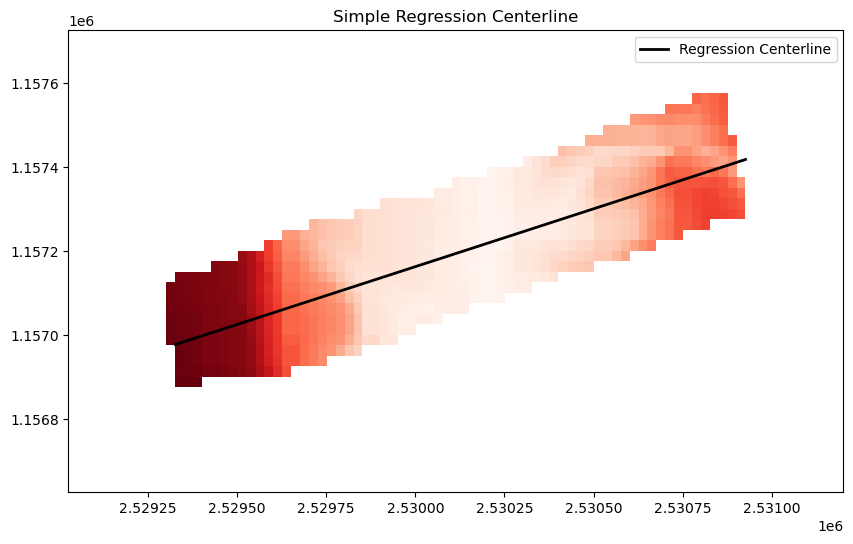

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def simple_regression_centerline(binary_mask, x_mesh, y_mesh):
    """
    Find a centerline using simple linear regression
    """
    # Get coordinates of all points in the mask
    rows, cols = np.where(binary_mask)
    
    # Map to original coordinate system
    x_coords = x_mesh[rows, cols] + 25/2
    y_coords = y_mesh[rows, cols] - 25/2
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_coords, y_coords)
    
    # Create evenly spaced points along the x-axis
    x_line = np.linspace(np.min(x_coords), np.max(x_coords), 50)
    y_line = slope * x_line + intercept
    
    # Combine into centerline points
    centerline = np.column_stack([x_line, y_line])
    
    return centerline

# Use the function
reg_centerline = simple_regression_centerline(binary_mask, x_mesh, y_mesh)

# Plot the result
fig, ax = plt.subplots(figsize=(10, 6))
ax.pcolormesh(x_mesh, y_mesh, np.where(binary_mask, patch_data, np.nan), 
              cmap='Reds', shading='auto')
ax.plot(reg_centerline[:, 0], reg_centerline[:, 1], '-', 
        color='black', linewidth=2, label='Regression Centerline')
ax.legend()
ax.set_title("Simple Regression Centerline")
plt.show()

PCA

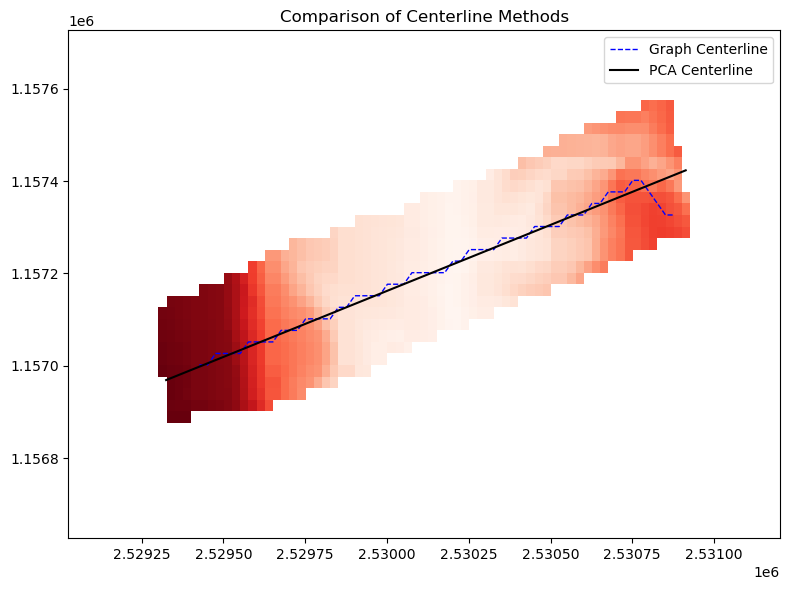

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def pca_centerline(binary_mask, x_mesh, y_mesh):

    # Get coordinates of mask points
    mask_coords = np.column_stack(np.where(binary_mask))
    
    # Convert to original coordinate system
    coord_points = np.array([
        x_mesh[mask_coords[:, 0], mask_coords[:, 1]] + 25/2,
        y_mesh[mask_coords[:, 0], mask_coords[:, 1]] - 25/2
    ]).T
    
    # Apply PCA to find the principal axis
    pca = PCA(n_components=2)
    pca.fit(coord_points)
    
    # Get the extent of data along the principal component
    projected = pca.transform(coord_points)
    min_proj = projected[:, 0].min()
    max_proj = projected[:, 0].max()
    
    # Generate points along principal axis
    line_points = np.zeros((100, 2))
    line_points[:, 0] = np.linspace(min_proj, max_proj, 100)
    
    # Transform back to original space
    centerline = pca.inverse_transform(line_points)
    
    return centerline

# Apply PCA centerline extraction
pca_line = pca_centerline(binary_mask, x_mesh, y_mesh)

# Get the original graph-based centerline for comparison
centerline, clean_skeleton = get_clean_centerline(binary_mask, x_mesh, y_mesh)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))

# Plot 1: Show centerline on original data
ax.pcolormesh(x_mesh, y_mesh, np.where(binary_mask, patch_data, np.nan), 
                  cmap='Reds', shading='auto')
if centerline is not None:
    ax.plot(centerline[:, 0], centerline[:, 1], '--', color='blue', 
                label='Graph Centerline', linewidth=1)
ax.plot(pca_line[:, 0], pca_line[:, 1], '-', color='black', 
            label='PCA Centerline', linewidth=1.5)
ax.legend()
ax.set_title("Comparison of Centerline Methods")

# Plot 2: PCA transformation visualization
mask_coords = np.column_stack(np.where(binary_mask))
coord_points = np.array([
    x_mesh[mask_coords[:, 0], mask_coords[:, 1]] + 25/2,
    y_mesh[mask_coords[:, 0], mask_coords[:, 1]] - 25/2
]).T


plt.tight_layout()
plt.show()

Moments

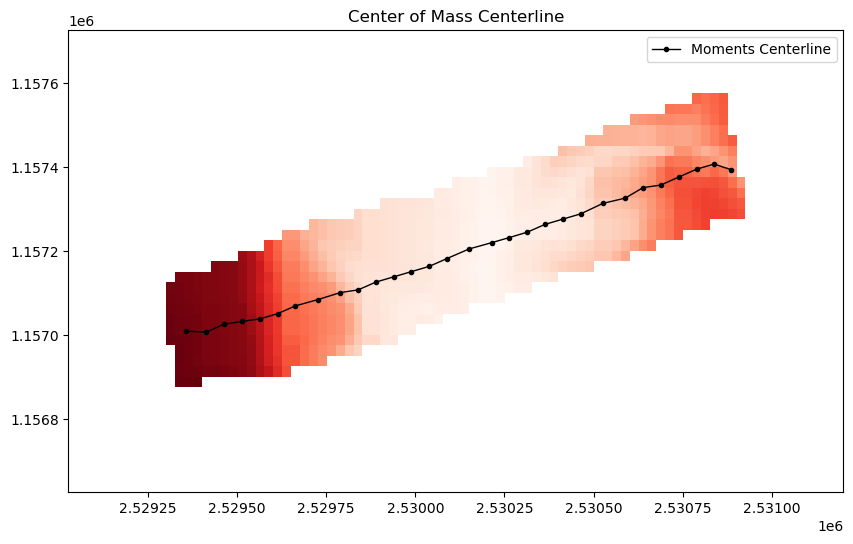

In [44]:
def moments_centerline(binary_mask, x_mesh, y_mesh):
    """
    Find centerline using image moments (center of mass) in vertical slices
    """
    # Get the x range
    rows, cols = np.where(binary_mask)
    x_min = np.min(x_mesh[rows, cols])
    x_max = np.max(x_mesh[rows, cols])
    
    num_slices = 30
    x_ranges = np.linspace(x_min, x_max, num_slices+1)
    
    centerline_points = []
    
    # Process each vertical slice
    for i in range(num_slices):
        # Create mask for this vertical slice
        slice_mask = binary_mask.copy()
        x_low, x_high = x_ranges[i], x_ranges[i+1]
        
        # Keep only points in this x range
        for r in range(slice_mask.shape[0]):
            for c in range(slice_mask.shape[1]):
                if x_mesh[r, c] < x_low or x_mesh[r, c] >= x_high:
                    slice_mask[r, c] = 0
        
        # Find center of mass for this slice
        if np.sum(slice_mask) > 0:
            r_indices, c_indices = np.where(slice_mask)
            center_x = np.mean(x_mesh[r_indices, c_indices]) + 25/2
            center_y = np.mean(y_mesh[r_indices, c_indices]) - 25/2
            centerline_points.append([center_x, center_y])
    
    return np.array(centerline_points)

# Use the function
moment_centerline = moments_centerline(binary_mask, x_mesh, y_mesh)

# Plot result
fig, ax = plt.subplots(figsize=(10, 6))
ax.pcolormesh(x_mesh, y_mesh, np.where(binary_mask, patch_data, np.nan), 
             cmap='Reds', shading='auto')
ax.plot(moment_centerline[:, 0], moment_centerline[:, 1], 'o-', 
       color='black', linewidth=1, markersize=3, label='Moments Centerline')
ax.legend()
ax.set_title("Center of Mass Centerline")
plt.show()

On part avec la droite PCA

Start Point: [2530113.7190037  1157210.56369141]
Direction Vector: [0.96143426 0.27503483]


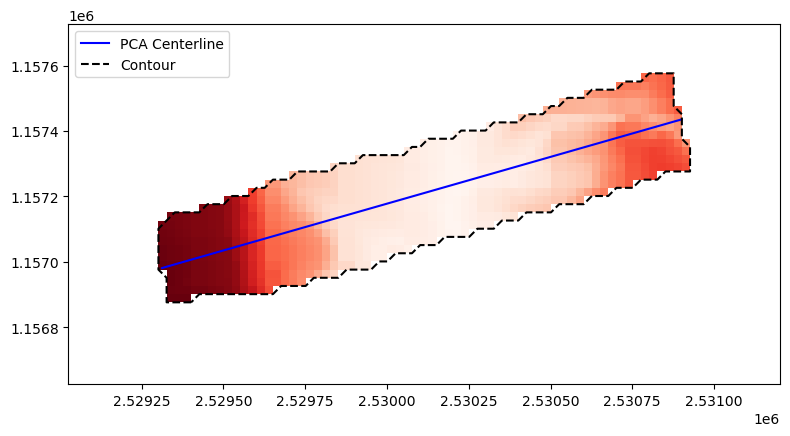

In [ ]:
def pca_centerline(binary_mask, x_mesh, y_mesh):
    # Get coordinates of mask points
    mask_coords = np.column_stack(np.where(binary_mask))

    # Convert to original coordinate system
    coord_points = np.array([
        x_mesh[mask_coords[:, 0], mask_coords[:, 1]],
        y_mesh[mask_coords[:, 0], mask_coords[:, 1]]
    ]).T
    
    # Apply PCA to find the principal axis
    pca = PCA(n_components=2)
    pca.fit(coord_points)
    
    # Get the extent of data along the principal component
    projected = pca.transform(coord_points)
    min_proj = projected[:, 0].min()
    max_proj = projected[:, 0].max()
    
    # Generate points along principal axis
    line_points = np.zeros((100, 2))
    line_points[:, 0] = np.linspace(min_proj, max_proj, 100)
    
    # Transform back to original space
    centerline = pca.inverse_transform(line_points)

    # Compute the start point (mean of the mask)
    start_point = pca.mean_

    # Principal direction vector (unit vector)
    direction_vector = pca.components_[0]    

    return centerline

centerline = pca_centerline(binary_mask, x_mesh, y_mesh)



def create_patches(length, width, distance, start, direction):
    patches = []
    
    
    # Perpendicular direction for width
    perpendicular = np.array([-direction[1], direction[0]])

    # Generate patches along the line
    num_patches = int(np.linalg.norm(direction) * 1000 / distance)  # Define the number of patches based on distance
    for i in range(num_patches):
        # Calculate position along the principal axis
        offset = i * distance
        center = start + offset * direction
        
        # Create the corners of the rectangle (patch)
        half_length = length / 2
        half_width = width / 2
        
        # Compute the corners of the rectangle by offsetting from the center
        rect_corners = np.array([
            center + half_length * direction + half_width * perpendicular,
            center + half_length * direction - half_width * perpendicular,
            center - half_length * direction - half_width * perpendicular,
            center - half_length * direction + half_width * perpendicular
        ])
        
        # Create polygon for the patch
        patch_polygon = Polygon(rect_corners)
        patches.append(patch_polygon)
    
    return patches

# Example of creating patches
patches = create_patches(band_length, band_width, sample_distance, start, direction)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))

# Plot 1: Show centerline on original data
ax.pcolormesh(x_mesh, y_mesh, np.where(binary_mask, patch_data, np.nan), 
                  cmap='Reds', shading='auto')

ax.plot(centerline[:, 0], centerline[:, 1], '-', color='blue', 
            label='PCA Centerline', linewidth=1.5)
ax.plot(contour_coords[:,0], contour_coords[:,1], '--', color='black', label='Contour')

ax.legend()

plt.tight_layout()
ax.set_aspect('equal')
plt.show()


[[2530894.80042826 1157486.01112457]
 [2530922.30391162 1157389.86769836]
 [2530874.23219851 1157376.11595668]
 [2530846.72871515 1157472.25938289]
 [2530894.80042826 1157486.01112457]]


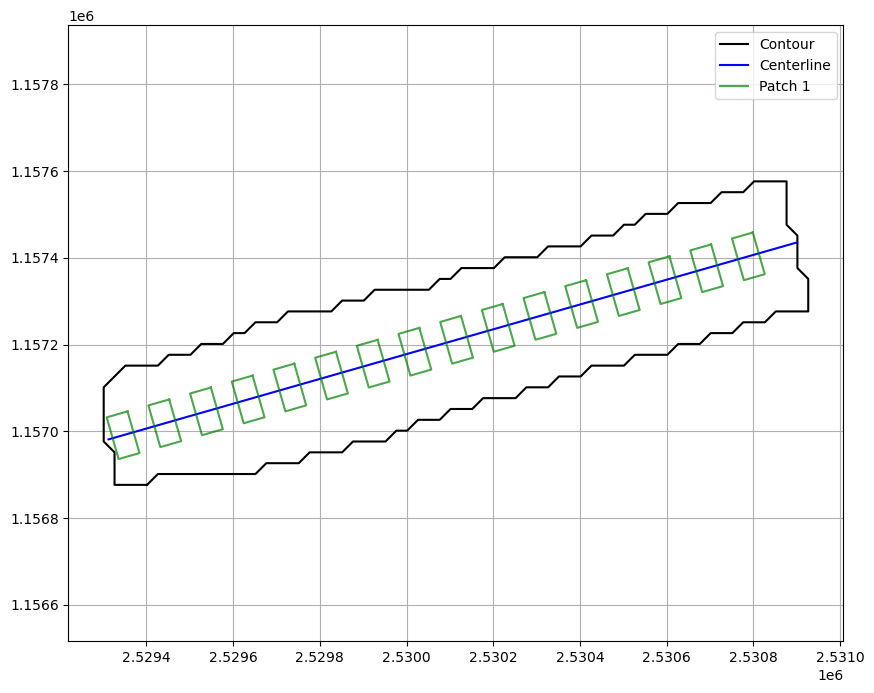

In [120]:
from shapely.geometry import Polygon, LineString

def create_patches_along_centerline(centerline, contour, band_length, band_width, sample_distance):

    # Convert contour to Shapely polygon
    contour_polygon = Polygon(contour)
    
    # Convert centerline to Shapely LineString
    centerline_line = LineString(centerline)
    
    if len(centerline) < 2:
        raise ValueError("Centerline must have at least two points")
    
    direction = centerline[-1] - centerline[0]
    direction = direction / np.linalg.norm(direction)  # Normalize
    
    # perpendicular direction 
    perp_direction = np.array([-direction[1], direction[0]])    
    patches = []
    
    # Find valid starting point
    valid_start_found = False
    start_dist = 0
    
    while not valid_start_found and start_dist < centerline_line.length:
        
        # Get point at current distance along the centerline
        start_point = np.array(centerline_line.interpolate(start_dist).coords[0])
        
        # Create first patch
        patch = create_patch(start_point, direction, perp_direction, band_length, band_width)
        
        # Check if patch intersects with contour
        patch_poly = Polygon(patch)
        
        # est ce qu'on peut juste garder within?? enlevé not patch_poly.intersects(contour_polygon) or
        if patch_poly.within(contour_polygon):
            valid_start_found = True
            patches.append(patch)
        else:
            # Move start point forward
            start_dist += 5  # changer incrémentation?
    
    # If we couldn't find a valid starting point, return empty list
    if not valid_start_found:
        # ++ add error message 
        return []
    
    # Generate subsequent patches
    current_dist = start_dist + sample_distance
    
    # Assume constant direction -> see if we modif the center line to something not linear?
    # Add condition to see it middle patches are too wide, if so -> reduce the width
    while current_dist < centerline_line.length:
        # Get point at current distance along the centerline
        current_point = np.array(centerline_line.interpolate(current_dist).coords[0])
        
        # Create patch
        patch = create_patch(current_point, direction, perp_direction, band_length, band_width)
        patches.append(patch)
        
        # Move to next position
        current_dist += sample_distance
        
    # check for last patch not to intersect the contour, remove it if it does 
    last_patch = patches[-1]
    print(last_patch)
    last_patch_poly = Polygon(last_patch)
    if not last_patch_poly.within(contour_polygon):
        patches.pop()
    
    return patches

def create_patch(center, direction, perp_direction, length, width):

    # Calculate half-dimensions
    half_length = length / 2
    half_width = width / 2
    
    # Calculate four corners of the rectangle
    corner1 = center + half_length * direction + half_width * perp_direction
    corner2 = center + half_length * direction - half_width * perp_direction
    corner3 = center - half_length * direction - half_width * perp_direction
    corner4 = center - half_length * direction + half_width * perp_direction
    
    # Create patch (closed polygon)
    patch = np.array([corner1, corner2, corner3, corner4, corner1])
    
    return patch


# parameter to extract patches
band_length = 50
band_width = 100
sample_distance = 100

# Get patches
patches = create_patches_along_centerline(centerline, contour_coords, band_length, band_width, sample_distance)

# Visualization (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

# Plot contour
plt.plot(contour_coords[:, 0], contour_coords[:, 1], 'black', label='Contour')

# Plot centerline
plt.plot(centerline[:, 0], centerline[:, 1], 'b-', label='Centerline')

# Plot patches
for i, patch in enumerate(patches):
    plt.plot(patch[:, 0], patch[:, 1], 'g-', alpha=0.7, label=f'Patch {i+1}' if i==0 else "")

plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

jouer avec les .las 

In [60]:
import laspy 

In [105]:
las_file = 'Data/ALS1_baseline.las'
output_file = 'Output/patch_1.las'
las = laspy.read(las_file)
las.header.point_count


31568859

In [106]:
point_format = las.point_format
print(list(point_format.dimensions))

[DimensionInfo(name='X', kind=<DimensionKind.SignedInteger: 0>, num_bits=32, num_elements=1, is_standard=True, description='', offsets=None, scales=None), DimensionInfo(name='Y', kind=<DimensionKind.SignedInteger: 0>, num_bits=32, num_elements=1, is_standard=True, description='', offsets=None, scales=None), DimensionInfo(name='Z', kind=<DimensionKind.SignedInteger: 0>, num_bits=32, num_elements=1, is_standard=True, description='', offsets=None, scales=None), DimensionInfo(name='intensity', kind=<DimensionKind.UnsignedInteger: 1>, num_bits=16, num_elements=1, is_standard=True, description='', offsets=None, scales=None), DimensionInfo(name='return_number', kind=<DimensionKind.BitField: 3>, num_bits=3, num_elements=1, is_standard=True, description='', offsets=None, scales=None), DimensionInfo(name='number_of_returns', kind=<DimensionKind.BitField: 3>, num_bits=3, num_elements=1, is_standard=True, description='', offsets=None, scales=None), DimensionInfo(name='scan_direction_flag', kind=<D

In [107]:
coords_EN = np.vstack((las.x, las.y)).transpose()
patch = patches[0]
patch_poly = Polygon(patch)

from shapely.geometry import Point

first_coord = Point(coords_EN[0])
mask = np.array([patch_poly.contains(Point(px, py)) for px, py in coords_EN])


KeyboardInterrupt: 

pour un patch bcp trop long..4min27s
voir pour d'abord faire une query sur la zone en question pour réduire la taille de la variable des coordonnées 
et ensuite check plus préciséement si chaque point est dedans ou non

In [108]:
print(patch_poly.bounds)

(2529308.4338958263, 1156936.0602228963, 2529384.009092292, 1157045.955390785)


In [109]:
# Get bounding box of polygon
min_x, min_y, max_x, max_y = patch_poly.bounds

# Filtering the las X,Y coords with bounding box of patch 
bbox_mask = ((coords_EN[:, 0] >= min_x) & (coords_EN[:, 0] <= max_x) & 
             (coords_EN[:, 1] >= min_y) & (coords_EN[:, 1] <= max_y))

# Only check points in bounding box with exact polygon 
points_in_bbox = coords_EN[bbox_mask]
final_mask = np.zeros_like(bbox_mask)
final_mask[bbox_mask] = [patch_poly.contains(Point(px, py)) for px, py in points_in_bbox]

In [112]:
import copy 
import os

os.makedirs("Output", exist_ok=True)

if np.any(final_mask):
    # keep the same header except the number of point ?

    new_header = copy.deepcopy(las.header)
    filtered_point_count = np.sum(final_mask)
    new_header.point_count = filtered_point_count
    
    # Create a new LAS file with the adjusted header
    new_las = laspy.LasData(new_header)    
    
    # Copy all point attributes while preserving IDs
    for dimension in las.point_format.dimension_names:
        data = getattr(las, dimension)
        setattr(new_las, dimension, data[final_mask])

    # Save filtered points into a new LAS file
    output_file = "Output/patch_1.las"
    new_las.write(output_file)
    print(f"Saved {np.sum(final_mask)} points inside the patch to {output_file}")
else:
    print("No points found inside the patch.")

Saved 256739 points inside the patch to Output/patch_1.las


In [76]:
print(coords[:10])

[[2530979.24 1157255.17]
 [2530978.97 1157256.01]
 [2530979.92 1157252.99]
 [2530979.87 1157253.15]
 [2530979.15 1157255.42]
 [2530981.71 1157247.34]
 [2530979.06 1157255.64]
 [2530979.01 1157255.8 ]
 [2530979.29 1157254.92]
 [2530978.75 1157256.62]]


## Pipeline

Avec les données d'un vol: 
1. Faire la moyenne des coordonnées pour centrer le vol sur le graph
2. Si deuxième vol, faire moyenne des deux pour toujours avoir le centre, 
3. Trouver le patch size en fonction de la longueur des vols (genre ± 250 m dans les direction du vols et plus sur les cotés)
4. Faire un mask_observed par vol 
5. Plot le MNT avec ce centre et les vols
6. Paramètre plot 2D ou 3D 
7. Faire un mask combiné => observed_mask_1 & observed_mask_2
8. Faire un fit d'un rectange par rapport au mask combiné 
9. Extraire axe de superposition PCA? médiane?

Notes: 

- comparer différentes méthodes pour la centerline 
- plus rigoureux si on coupe les bouts de manière générale mais le skeleton est un peu nul après
- PEUT ETRE ERREUR: dans les observed_mask comment on doit rajouter les 25/2


Questions: 


A modifier: 
- les ± 250 au coordonnées E_min, max etc. à changer car dépendant de l'altitude de vol donc prendre en compte la FOV 
- couper les bout car le lidar regarde horizontalement?